In [2]:
pip install scikit-learn pandas numpy matplotlib seaborn pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 796.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 8.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 995.1 kB/s eta 0:00:00:010m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 2.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 4.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301

In [37]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col, isnan, when, count, mean, min, max, stddev, percentile_approx
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql.types import DoubleType
import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder \
    .appName("CustomerSegmentation") \
    .config("spark.driver.memory", "30g") \
    .config("spark.executor.memory", "30g") \
    .config("spark.executor.memoryOverhead", "18g") \
    .config("spark.driver.maxResultSize", "18g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "4") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "2") \
    .config("spark.dynamicAllocation.maxExecutors", "10") \
    .config("spark.dynamicAllocation.initialExecutors", "4") \
    .config("spark.default.parallelism", "200") \
    .config("spark.sql.shuffle.partitions", "200") \
    .enableHiveSupport() \
    .getOrCreate()


In [38]:
# Load data
df = spark.read.csv("ctzn_1_years_data.csv", header=True, inferSchema=True)

# Display basic information
print("Total number of records:", df.count())
print("Schema:")
df.printSchema()

Total number of records: 191559
Schema:
root
 |-- cif_id: string (nullable = true)
 |-- schm_type: string (nullable = true)
 |-- balance: double (nullable = true)
 |-- balance_frequency: integer (nullable = true)
 |-- purchases: double (nullable = true)
 |-- oneoff_purchases: double (nullable = true)
 |-- installments_purchases: double (nullable = true)
 |-- cash_advance: double (nullable = true)
 |-- purchases_frequency: integer (nullable = true)
 |-- oneoff_purchases_frequency: integer (nullable = true)
 |-- purchases_installments_frequency: integer (nullable = true)
 |-- cash_advance_frequency: integer (nullable = true)
 |-- cash_advance_trx: integer (nullable = true)
 |-- purchases_trx: integer (nullable = true)
 |-- payments: double (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- minimum_payments: double (nullable = true)
 |-- prc_full_payment: integer (nullable = true)
 |-- credit_limit: double (nullable = true)



In [39]:
# Calculate basic statistics
stats = df.select([min(col("balance")).alias("min_balance"),
                  max(col("balance")).alias("max_balance"),
                  mean(col("balance")).alias("mean_balance")])
stats.show()


+---------------+-----------+-------------------+
|    min_balance|max_balance|       mean_balance|
+---------------+-----------+-------------------+
|-1.0476237418E9|      4.4E9|-18909.956332095866|
+---------------+-----------+-------------------+



In [40]:
def describe_data(df):
    # Select only numeric columns
    numeric_cols = [field.name for field in df.schema.fields if isinstance(df.schema[field.name].dataType, DoubleType) 
                    or str(df.schema[field.name].dataType).startswith('IntegerType') 
                    or str(df.schema[field.name].dataType).startswith('LongType')]
    
    # Create a list of expressions for all statistics
    expr_list = []
    for c in numeric_cols:
        expr_list.extend([
            mean(col(c)).alias(f"{c}_mean"),
            stddev(col(c)).alias(f"{c}_stddev"),
            min(col(c)).alias(f"{c}_min"),
            max(col(c)).alias(f"{c}_max"),
            percentile_approx(col(c), 0.25).alias(f"{c}_25%"),
            percentile_approx(col(c), 0.5).alias(f"{c}_50%"),
            percentile_approx(col(c), 0.75).alias(f"{c}_75%")
        ])
    
    # Calculate statistics for each column
    result = df.select(expr_list).collect()[0]
    
    # Convert to pandas DataFrame for better display
    stats_dict = {}
    for c in numeric_cols:
        stats_dict[c] = {
            "mean": result[f"{c}_mean"],
            "stddev": result[f"{c}_stddev"],
            "min": result[f"{c}_min"],
            "max": result[f"{c}_max"],
            "25%": result[f"{c}_25%"],
            "50%": result[f"{c}_50%"],
            "75%": result[f"{c}_75%"]
        }
    
    return pd.DataFrame.from_dict(stats_dict, orient='index')

# Get data description
desc_df = describe_data(df)
print(desc_df)

                                          mean        stddev           min  \
balance                          -1.890996e+04  1.294663e+07 -1.047624e+09   
balance_frequency                 0.000000e+00  0.000000e+00  0.000000e+00   
purchases                         6.528741e+06  3.951343e+08  0.000000e+00   
oneoff_purchases                  1.686180e+06  7.236131e+07  0.000000e+00   
installments_purchases            4.842561e+06  3.280877e+08  0.000000e+00   
cash_advance                      1.307930e+05  2.434063e+07  0.000000e+00   
purchases_frequency               4.179642e+00  2.692307e+01  0.000000e+00   
oneoff_purchases_frequency        2.988113e-02  1.702598e-01  0.000000e+00   
purchases_installments_frequency  0.000000e+00  0.000000e+00  0.000000e+00   
cash_advance_frequency            7.520764e-01  4.318084e-01  0.000000e+00   
cash_advance_trx                  3.849467e-02  3.508215e-01  0.000000e+00   
purchases_trx                     1.004667e+00  1.107870e+00  0.

In [41]:
# Check for missing values
def missing_values(df):
    return df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df.columns]).collect()[0].asDict()

missing = missing_values(df)
missing_df = pd.DataFrame.from_dict(missing, orient='index', columns=['count'])
missing_df = missing_df.sort_values('count', ascending=False)
print("Missing values by column:")
print(missing_df[missing_df['count'] > 0])

Missing values by column:
Empty DataFrame
Columns: [count]
Index: []


In [42]:
# Fill missing values for credit_limit with mean
credit_limit_mean = df.select(mean(col("credit_limit"))).collect()[0][0]
df = df.withColumn("credit_limit", 
                  when(col("credit_limit").isNull(), credit_limit_mean)
                  .otherwise(col("credit_limit")))

In [43]:
# Handle outliers using Z-score method instead of IQR
def handle_outliers_zscore(df, cols, threshold=3.0):
    """Handle outliers in spark dataframe using z-score method"""
    for c in cols:
        # Calculate mean and standard deviation
        stats = df.select(mean(col(c)).alias("mean"), stddev(col(c)).alias("stddev")).collect()[0]
        mean_val, stddev_val = stats["mean"], stats["stddev"]
        
        # If stddev is 0 or null, skip this column
        if stddev_val is None or stddev_val == 0:
            continue
            
        # Replace outliers with threshold values
        df = df.withColumn(
            c,
            when((col(c) - mean_val) / stddev_val > threshold, mean_val + threshold * stddev_val)
            .when((col(c) - mean_val) / stddev_val < -threshold, mean_val - threshold * stddev_val)
            .otherwise(col(c))
        )
    return df

In [44]:
# Get numeric columns
numeric_cols = [field.name for field in df.schema.fields 
                if (isinstance(df.schema[field.name].dataType, DoubleType) 
                    or str(df.schema[field.name].dataType).startswith('IntegerType') 
                    or str(df.schema[field.name].dataType).startswith('LongType'))
                and field.name != "cif_id"]

# Handle outliers in numeric columns
df = handle_outliers_zscore(df, numeric_cols)

In [45]:
# Create feature engineering columns
df = df.withColumn("new_balance_balance_frequency", col("balance") * col("balance_frequency"))
df = df.withColumn("new_oneoff_purchases_purchases", 
                  when(col("purchases") != 0, col("oneoff_purchases") / col("purchases")).otherwise(0))
df = df.withColumn("new_installments_purchases_purchases", 
                  when(col("purchases") != 0, col("installments_purchases") / col("purchases")).otherwise(0))
df = df.withColumn("new_cash_advance_purchases_purchases", col("cash_advance") * col("cash_advance_frequency"))
df = df.withColumn("new_purchases_purchases_frequency", col("purchases") * col("purchases_frequency"))
df = df.withColumn("new_purchases_oneoff_purchases_frequency", col("purchases") * col("oneoff_purchases_frequency"))
df = df.withColumn("new_purchases_purchases_trx", 
                  when(col("purchases_trx") != 0, col("purchases") / col("purchases_trx")).otherwise(0))
df = df.withColumn("new_cash_advance_cash_advance_trx", 
                  when(col("cash_advance_trx") != 0, col("cash_advance") / col("cash_advance_trx")).otherwise(0))
df = df.withColumn("new_balance_credit_limit", 
                  when(col("credit_limit") != 0, col("balance") / col("credit_limit")).otherwise(0))
df = df.withColumn("new_payments_credit_limit", 
                  when(col("minimum_payments") != 0, col("payments") / col("minimum_payments")).otherwise(0))

# Fill remaining NaN values with 0
df = df.na.fill(0)

# Prepare features for clustering (drop cif_id)
if "cif_id" in df.columns:
    features_df = df.drop("cif_id")
else:
    features_df = df

In [46]:
# Filter out non-numeric columns for the assembler
from pyspark.sql.types import NumericType

# Get only numeric column names
numeric_cols = [col_name for col_name, dtype in features_df.dtypes 
                if dtype != 'string' and not dtype.startswith('array') 
                and not col_name == 'cif_id']  # Assuming you want to exclude cif_id

# Assemble features into a vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
assembled_data = assembler.transform(features_df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

In [47]:
# Apply PCA for dimensionality reduction
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_data)
pca_data = pca_model.transform(scaled_data)

# Explained variance ratio
explained_variance = pca_model.explainedVariance.toArray()
print("Explained variance ratio:", explained_variance)
print("Total variance explained:", sum(explained_variance))

Explained variance ratio: [0.2287108  0.12808795]
Total variance explained: 0.3567987476747583


In [48]:
def find_optimal_clusters(data, max_k=10):
    """Find optimal number of clusters using Elbow method and Silhouette score"""
    costs = []
    silhouettes = []
    evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="pca_features", 
                                   metricName="silhouette")
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(k=k, seed=42, featuresCol="pca_features")
        model = kmeans.fit(data)
        cost = model.summary.trainingCost
        costs.append(cost)
        
        # Make predictions
        predictions = model.transform(data)
        silhouette = evaluator.evaluate(predictions)
        silhouettes.append(silhouette)
        
        print(f"k={k}, Cost={cost}, Silhouette Score={silhouette}")
    
    return costs, silhouettes

# Find optimal number of clusters
costs, silhouettes = find_optimal_clusters(pca_data, max_k=10)


k=2, Cost=772862.9659071012, Silhouette Score=0.9981988551404122


k=3, Cost=399533.8615391177, Silhouette Score=0.998699872839008


k=4, Cost=293058.4168081172, Silhouette Score=0.9953064135026531


k=5, Cost=193889.50055738803, Silhouette Score=0.9959684897513303


k=6, Cost=152039.30350391052, Silhouette Score=0.9909443358246698


k=7, Cost=129104.21747654148, Silhouette Score=0.9912117907294834


k=8, Cost=102675.3252526976, Silhouette Score=0.966305814129383


k=9, Cost=100140.61855433285, Silhouette Score=0.922673164721057


k=10, Cost=79860.25433923118, Silhouette Score=0.9657404426832286


In [49]:
# # Convert to pandas DataFrames for plotting
# elbow_df = pd.DataFrame({'k': range(2, len(costs) + 2), 'cost': costs})
# silhouette_df = pd.DataFrame({'k': range(2, len(silhouettes) + 2), 'silhouette': silhouettes})

# # Determine optimal k (highest silhouette score)
# optimal_k = silhouette_df.loc[silhouette_df['silhouette'].idxmax(), 'k']
# print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

Optimal number of clusters based on silhouette score: 3


In [62]:
# Find optimal number of clusters
costs, silhouettes = find_optimal_clusters(pca_data, max_k=10)

# Convert to pandas DataFrames for plotting
elbow_df = pd.DataFrame({'k': range(2, len(costs) + 2), 'cost': costs})
silhouette_df = pd.DataFrame({'k': range(2, len(silhouettes) + 2), 'silhouette': silhouettes})

# Determine optimal k (highest silhouette score)
optimal_k = silhouette_df.loc[silhouette_df['silhouette'].idxmax(), 'k']
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")


k=2, Cost=772862.9659071012, Silhouette Score=0.9981988551404122


k=3, Cost=399533.86153911764, Silhouette Score=0.998699872839008


k=4, Cost=293058.4168081171, Silhouette Score=0.9953064135026531


k=5, Cost=193889.50055738803, Silhouette Score=0.9959684897513303


k=6, Cost=152039.30350391052, Silhouette Score=0.9909443358246698


k=7, Cost=129104.21747654148, Silhouette Score=0.9912117907294834


k=8, Cost=102675.3252526976, Silhouette Score=0.966305814129383


k=9, Cost=100140.61855433285, Silhouette Score=0.922673164721057


k=10, Cost=79860.25433923118, Silhouette Score=0.9657404426832286
Optimal number of clusters based on silhouette score: 3


In [63]:
optimal_k = 9

kmeans = KMeans(k=int(optimal_k), seed=42, featuresCol="pca_features")
kmeans_model = kmeans.fit(pca_data)
clustered_data = kmeans_model.transform(pca_data)

In [64]:
pandas_df = clustered_data.select("pca_features", "prediction").toPandas()
pandas_df['pca1'] = pandas_df['pca_features'].apply(lambda x: float(x[0]))
pandas_df['pca2'] = pandas_df['pca_features'].apply(lambda x: float(x[1]))

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pandas_df['pca1'], pandas_df['pca2'], c=pandas_df['prediction'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.title('Customer Segmentation - PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('cluster_visualization.png')
plt.close()


In [65]:
def analyze_clusters(df, feature_cols, id_col=None, num_key_features=5):
    from pyspark.sql.functions import col
    import pandas as pd

    # Limit to just what's needed (numeric feature columns and prediction)
    analysis_cols = [c for c in feature_cols if c != id_col]

    # Select only necessary columns and cast to float (avoid mixed types)
    selected_df = df.select(["prediction"] + analysis_cols)
    for col_name in analysis_cols:
        selected_df = selected_df.withColumn(col_name, col(col_name).cast("double"))

    # Collect a sample if needed (optional, uncomment if too large)
    # selected_df = selected_df.sample(False, 0.5, seed=42)

    # Collect to Pandas
    pandas_df = selected_df.toPandas()

    # Group by cluster and compute means
    cluster_profiles = pandas_df.groupby("prediction")[analysis_cols].mean()

    # Overall means for comparison
    overall_means = pandas_df[analysis_cols].mean()

    # Calculate relative importance
    relative_importance = cluster_profiles.copy()
    for col in analysis_cols:
        if overall_means[col] != 0:
            relative_importance[col] = (cluster_profiles[col] - overall_means[col]) / overall_means[col]
        else:
            relative_importance[col] = cluster_profiles[col] - overall_means[col]

    # Identify key features per cluster
    key_features = {}
    for cluster in cluster_profiles.index:
        top_features = relative_importance.loc[cluster].abs().sort_values(ascending=False).head(num_key_features).index.tolist()
        key_features[cluster] = top_features

    return cluster_profiles, relative_importance, key_features


In [66]:
# Define correct feature columns
feature_cols = [col_name for col_name in features_df.columns if col_name != "cif_id"]

# Analyze clusters (optimized)
cluster_profiles, relative_importance, key_features = analyze_clusters(
    clustered_data, feature_cols, id_col="cif_id" if "cif_id" in feature_cols else None
)


In [67]:
# Create a function to interpret clusters based on key features
def interpret_clusters(cluster_profiles, relative_importance, key_features):
    """Generate interpretations for each cluster"""
    interpretations = {}
    
    for cluster in key_features.keys():
        features = key_features[cluster]
        profile = ""
        
        # Analyze spending patterns
        if any(f in features for f in ['purchases', 'oneoff_purchases', 'installments_purchases', 
                                     'new_oneoff_purchases_purchases', 'new_installments_purchases_purchases']):
            spend_level = cluster_profiles.loc[cluster, 'purchases'] if 'purchases' in cluster_profiles.columns else 0
            oneoff_ratio = cluster_profiles.loc[cluster, 'new_oneoff_purchases_purchases'] if 'new_oneoff_purchases_purchases' in cluster_profiles.columns else 0
            install_ratio = cluster_profiles.loc[cluster, 'new_installments_purchases_purchases'] if 'new_installments_purchases_purchases' in cluster_profiles.columns else 0
            
            if spend_level > cluster_profiles['purchases'].mean() * 1.2:
                profile += "High spenders; "
            elif spend_level < cluster_profiles['purchases'].mean() * 0.8:
                profile += "Low spenders; "
                
            if oneoff_ratio > install_ratio * 1.2:
                profile += "Prefers one-time purchases; "
            elif install_ratio > oneoff_ratio * 1.2:
                profile += "Prefers installment purchases; "
        
        # Analyze cash advance behavior
        if any(f in features for f in ['cash_advance', 'cash_advance_frequency', 'new_cash_advance_purchases_purchases']):
            cash_level = cluster_profiles.loc[cluster, 'cash_advance'] if 'cash_advance' in cluster_profiles.columns else 0
            cash_freq = cluster_profiles.loc[cluster, 'cash_advance_frequency'] if 'cash_advance_frequency' in cluster_profiles.columns else 0
            
            if cash_level > cluster_profiles['cash_advance'].mean() * 1.2 and cash_freq > cluster_profiles['cash_advance_frequency'].mean() * 1.2:
                profile += "Heavy cash advance users; "
            elif cash_level < cluster_profiles['cash_advance'].mean() * 0.8 and cash_freq < cluster_profiles['cash_advance_frequency'].mean() * 0.8:
                profile += "Rarely uses cash advances; "
        
        # Analyze balance and credit behavior
        if any(f in features for f in ['balance', 'credit_limit', 'new_balance_credit_limit']):
            balance_ratio = cluster_profiles.loc[cluster, 'new_balance_credit_limit'] if 'new_balance_credit_limit' in cluster_profiles.columns else 0
            
            if balance_ratio > 0.7:
                profile += "High balance-to-limit ratio (potentially at-risk); "
            elif balance_ratio < 0.3:
                profile += "Low balance-to-limit ratio (conservative); "
        
        # Analyze payment behavior
        if any(f in features for f in ['payments', 'minimum_payments', 'new_payments_credit_limit']):
            payment_ratio = cluster_profiles.loc[cluster, 'new_payments_credit_limit'] if 'new_payments_credit_limit' in cluster_profiles.columns else 0
            
            if payment_ratio > cluster_profiles['new_payments_credit_limit'].mean() * 1.2:
                profile += "Pays more than minimum; "
            elif payment_ratio < cluster_profiles['new_payments_credit_limit'].mean() * 0.8:
                profile += "Tends to pay minimum; "
        
        # Clean up and finalize the profile
        if profile:
            interpretations[cluster] = profile[:-2]  # Remove trailing "; "
        else:
            interpretations[cluster] = "No clear pattern identified"
    
    return interpretations


In [68]:
# Interpret clusters
cluster_interpretations = interpret_clusters(cluster_profiles, relative_importance, key_features)

# Print cluster interpretations
print("\nCluster Interpretations:")
for cluster, interpretation in cluster_interpretations.items():
    print(f"Cluster {cluster}: {interpretation}")



Cluster Interpretations:
Cluster 0: Low balance-to-limit ratio (conservative)
Cluster 1: High spenders; Prefers installment purchases; Tends to pay minimum
Cluster 2: Low balance-to-limit ratio (conservative)
Cluster 3: High spenders; Prefers installment purchases
Cluster 4: High spenders; Prefers installment purchases; Tends to pay minimum
Cluster 5: Low balance-to-limit ratio (conservative)
Cluster 6: Low balance-to-limit ratio (conservative)
Cluster 7: Low balance-to-limit ratio (conservative)
Cluster 8: Low spenders; Low balance-to-limit ratio (conservative)


In [69]:
# Save cluster profiles and interpretations to CSV
cluster_profiles.to_csv("spark_cluster_profiles.csv")
pd.DataFrame.from_dict(cluster_interpretations, orient='index', columns=['Interpretation']).to_csv("spark_cluster_interpretations.csv")

# optimization of the clusters

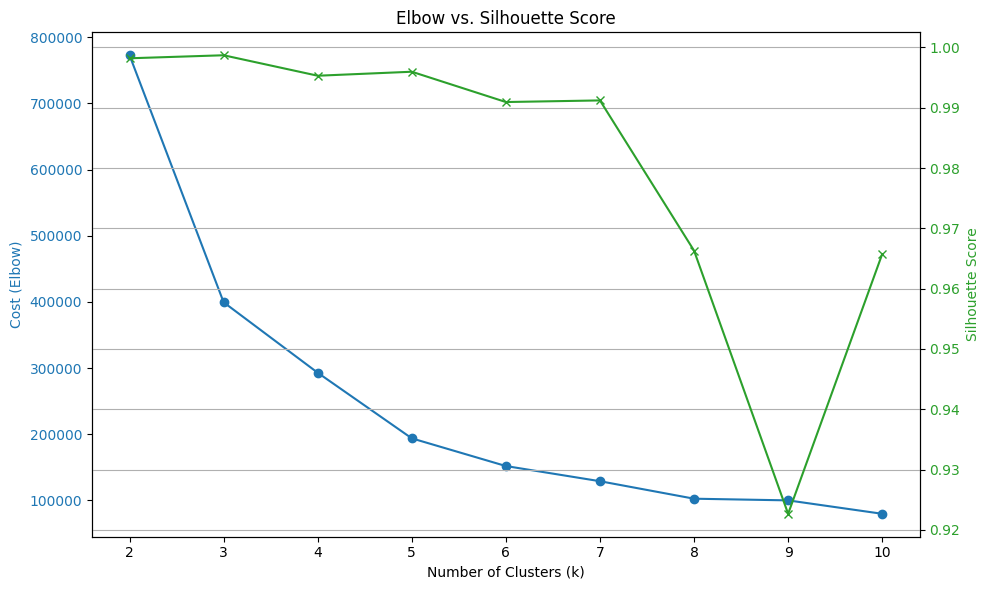

In [59]:
# Plot elbow (inertia/cost) and silhouette together
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Cost (Elbow)', color=color)
ax1.plot(elbow_df['k'], elbow_df['cost'], marker='o', color=color, label='Cost')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Second axis
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(silhouette_df['k'], silhouette_df['silhouette'], marker='x', color=color, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow vs. Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.savefig('cluster_diagnostics.png')
plt.show()


In [60]:
# Try a larger number of clusters manually
manual_k = 9 
kmeans = KMeans(k=manual_k, seed=42, featuresCol="pca_features")
kmeans_model = kmeans.fit(pca_data)
clustered_data = kmeans_model.transform(pca_data)

# Proceed with the same interpretation and profiling


In [61]:
# KMeans on original scaled features (not PCA)
kmeans = KMeans(k=9, seed=42, featuresCol="scaled_features")
kmeans_model = kmeans.fit(scaled_data)
clustered_data = kmeans_model.transform(scaled_data)


In [ ]:
from pyspark.ml.clustering import BisectingKMeans

bkm = BisectingKMeans(k=6, seed=42, featuresCol="pca_features")
model = bkm.fit(pca_data)
clustered_data = model.transform(pca_data)


# Spending Behaviour Clusters

In [70]:
# Define features for spending behavior analysis
spending_features = [
    "purchases",
    "oneoff_purchases",
    "installments_purchases",
    "purchases_frequency",
    "oneoff_purchases_frequency",
    "purchases_installments_frequency"
]

# Assemble selected features
assembler = VectorAssembler(inputCols=spending_features, outputCol="features")
assembled_data = assembler.transform(df)


In [71]:
# Standard scaling
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# Optional PCA
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_data)
pca_data = pca_model.transform(scaled_data)


In [72]:
from pyspark.ml.clustering import KMeans

k = 5  
kmeans = KMeans(k=k, seed=42, featuresCol="pca_features")  # or "scaled_features" if no PCA
kmeans_model = kmeans.fit(pca_data)
clustered_data = kmeans_model.transform(pca_data)

# Use only spending features
cluster_profiles, relative_importance, key_features = analyze_clusters(
    clustered_data, feature_cols=spending_features
)



In [73]:
for cluster, features in key_features.items():
    print(f"\nCluster {cluster} Spending Behavior:")
    for feature in features:
        value = relative_importance.loc[cluster, feature]
        direction = "higher" if value > 0 else "lower"
        print(f" - {feature}: {abs(value)*100:.1f}% {direction} than average")



Cluster 0 Spending Behavior:
 - purchases_frequency: 716.3% higher than average
 - oneoff_purchases: 493.7% higher than average
 - purchases: 347.2% higher than average
 - installments_purchases: 278.2% higher than average
 - oneoff_purchases_frequency: 99.1% lower than average

Cluster 1 Spending Behavior:
 - oneoff_purchases_frequency: 100.0% lower than average
 - installments_purchases: 90.5% lower than average
 - purchases: 83.8% lower than average
 - oneoff_purchases: 70.8% lower than average
 - purchases_frequency: 33.0% lower than average

Cluster 2 Spending Behavior:
 - oneoff_purchases_frequency: 3246.6% higher than average
 - oneoff_purchases: 113.7% higher than average
 - installments_purchases: 63.2% lower than average
 - purchases_frequency: 55.2% higher than average
 - purchases: 1.8% lower than average

Cluster 3 Spending Behavior:
 - installments_purchases: 62234.2% higher than average
 - purchases: 49564.9% higher than average
 - oneoff_purchases: 26671.7% higher than

In [74]:
# Save cluster profiles and interpretation
cluster_profiles.to_csv("spending_cluster_profiles.csv")
pd.DataFrame.from_dict(cluster_interpretations, orient='index', columns=['Interpretation']) \
    .to_csv("spending_cluster_interpretations.csv")


In [75]:
clustered_data = kmeans_model.transform(pca_data)

assembled_data = assembler.transform(df.select("cif_id", *spending_features))

scaled_data = scaler_model.transform(assembled_data)
pca_data = pca_model.transform(scaled_data)


# Select only cif_id and predicted cluster
customer_clusters = clustered_data.select("cif_id", col("prediction").alias("cluster_id"))

customer_clusters.write.mode("overwrite").csv("customer_segments_csv", header=True)



In [76]:
# Get cluster assignments with customer IDs
customer_clusters = clustered_data.select("cif_id", col("prediction").alias("cluster_id"))

# Save to CSV
customer_clusters.toPandas().to_csv("customer_segments.csv", index=False)


In [78]:
# Convert interpretations to DataFrame
interpretation_df = pd.DataFrame.from_dict(cluster_interpretations, orient='index', columns=['Cluster_Description'])
interpretation_df.reset_index(inplace=True)
interpretation_df.rename(columns={"index": "cluster_id"}, inplace=True)

# Get customer_clusters as Pandas
customer_clusters_pd = customer_clusters.toPandas()

# Merge descriptions with customer info
final_customer_segments = customer_clusters_pd.merge(interpretation_df, on='cluster_id', how='left')

# Save final output
final_customer_segments.to_csv("final_customer_segments_with_description.csv", index=False)


In [80]:
def interpret_clusters(cluster_profiles, relative_importance, key_features):
    """Generate richer interpretations for each cluster"""
    interpretations = {}

    for cluster in key_features.keys():
        features = key_features[cluster]
        profile = ""

        # Spending level
        spend_level = cluster_profiles.loc[cluster, 'purchases'] if 'purchases' in cluster_profiles.columns else 0
        avg_spend = cluster_profiles['purchases'].mean()
        if spend_level > avg_spend * 1.3:
            profile += "High spenders; "
        elif spend_level < avg_spend * 0.7:
            profile += "Low spenders; "
        else:
            profile += "Moderate spenders; "

        # Purchase behavior: One-off vs Installment
        oneoff = cluster_profiles.loc[cluster, 'oneoff_purchases'] if 'oneoff_purchases' in cluster_profiles.columns else 0
        installment = cluster_profiles.loc[cluster, 'installments_purchases'] if 'installments_purchases' in cluster_profiles.columns else 0

        if oneoff > installment * 1.3:
            profile += "Prefers one-time purchases; "
        elif installment > oneoff * 1.3:
            profile += "Prefers installment purchases; "
        else:
            profile += "Balanced purchase types; "

        # Frequency
        freq = cluster_profiles.loc[cluster, 'purchases_frequency'] if 'purchases_frequency' in cluster_profiles.columns else 0
        avg_freq = cluster_profiles['purchases_frequency'].mean()
        if freq > avg_freq * 1.3:
            profile += "Frequent shopper; "
        elif freq < avg_freq * 0.7:
            profile += "Infrequent shopper; "
        else:
            profile += "Moderate frequency; "

        # Cash advance behavior
        if 'cash_advance' in cluster_profiles.columns:
            cash_advance = cluster_profiles.loc[cluster, 'cash_advance']
            avg_cash = cluster_profiles['cash_advance'].mean()
            if cash_advance > avg_cash * 1.3:
                profile += "Uses cash advances frequently; "
            elif cash_advance < avg_cash * 0.7:
                profile += "Rarely uses cash advances; "

        # Final cleanup
        if profile:
            interpretations[cluster] = profile.rstrip("; ")
        else:
            interpretations[cluster] = "No clear pattern identified"

    return interpretations


In [81]:
cluster_interpretations = interpret_clusters(cluster_profiles, relative_importance, key_features)

# Convert interpretations to DataFrame
interpretation_df = pd.DataFrame.from_dict(cluster_interpretations, orient='index', columns=['Cluster_Description'])
interpretation_df.reset_index(inplace=True)
interpretation_df.rename(columns={"index": "cluster_id"}, inplace=True)

# Get customer_clusters as Pandas
customer_clusters_pd = customer_clusters.toPandas()

# Merge descriptions with customer info
final_customer_segments = customer_clusters_pd.merge(interpretation_df, on='cluster_id', how='left')

# Save final output
final_customer_segments.to_csv("final_customer_segments_with_description.csv", index=False)

